In [44]:
import Levenshtein
import os, json
import pandas as pd
import Levenshtein
import cv2
import requests
from tempfile import NamedTemporaryFile
from io import BytesIO
from PIL import Image
from cairosvg import svg2png
import matplotlib.pyplot as plt
import numpy as np

In [45]:
ROOT_DIR = os.path.abspath("../../")
data_dir = os.path.join(ROOT_DIR, "assets", "augmented_data")

with open(
    os.path.join(data_dir, "default-cards-20230101220647.json"), encoding="utf8"
) as f:
    cards = json.load(f)

cards = pd.DataFrame(cards)
print("hello", len(cards))

hello 78335


In [46]:
def get_scryfall(url):
    headers = {
        "User-Agent": "my-app/0.0.1",
        "Accept": "application/json;q=0.9,*/*;q=0.8",
    }

    response = requests.get(url, headers=headers)
    if response.status_code == 200:
        return response.content
    else:
        # handle error
        print(response.status_code)
        return None


url = "https://api.scryfall.com/sets"
resp = get_scryfall(url)

# Check that the request was successful
if resp:
    set_data = json.loads(resp)["data"]
    set_data = {x["code"]: x for x in set_data}

In [54]:
def get_unique_set_names(group):
    return set(group["set"])


def get_closest_match(input_string, dictionary):
    input_string = input_string.lower().strip()
    # If the input string is a key in the dictionary, return the value
    if input_string in dictionary:
        print(f"Found exact match: {input_string}")
        return [set_data[x]["icon_svg_uri"] for x in dictionary[input_string]]

    # Otherwise, initialize the closest match and best ratio to 0
    closest_match = None
    best_ratio = 0

    # Iterate through the dictionary
    for key in dictionary:
        # Calculate the ratio of similarity between the input string and the key
        ratio = Levenshtein.ratio(input_string, key)

        # If the ratio is greater than the best ratio so far, update the closest match and best ratio
        if ratio > best_ratio:
            closest_match = key
            best_ratio = ratio

    print(f"guessing with ratio of {ratio}: {closest_match}")
    # Return the value for the closest matching key
    return [set_data[x]["icon_svg_uri"] for x in dictionary[closest_match]]

In [48]:
set_names = {
    x.lower(): y
    for x, y in cards.groupby("name").apply(get_unique_set_names).to_dict().items()
}
expanded_names = {
    x.lower(): y
    for x, y in cards.groupby("name").apply(get_unique_set_names).to_dict().items()
}
for name, sets in set_names.items():
    if " // " in name:
        sp = name.split(" // ")
        expanded_names[sp[0]] = set_names.get(sp[0], set()).union(set_names[name])
        expanded_names[sp[1]] = set_names.get(sp[1], set()).union(set_names[name])

In [49]:
def load_set_image(url, width=None):
    print(url)
    svg_data = get_scryfall(url)
    png = svg2png(bytestring=svg_data, output_width=width)
    cv_img = cv2.imdecode(np.frombuffer(png, np.uint8), cv2.IMREAD_UNCHANGED)
    # Add border padding to the image so the edges aren't touching
    border_color = (255, 255, 255)  # white
    border_size = int(width / 45.0)
    cv_img = cv2.copyMakeBorder(
        cv_img,
        border_size,
        border_size,
        border_size,
        border_size,
        cv2.BORDER_CONSTANT,
        value=border_color,
    )
    return cv_img

Found exact match: ruby medallion
https://svgs.scryfall.io/sets/tmp.svg?1672635600


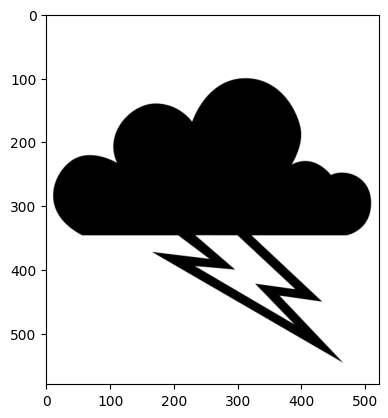

https://svgs.scryfall.io/sets/cm2.svg?1672635600


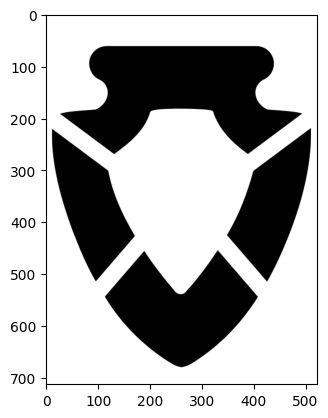

https://svgs.scryfall.io/sets/c14.svg?1672635600


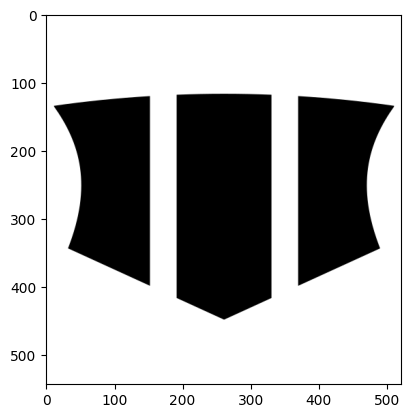

In [55]:
for img_url in get_closest_match("Ruby Medallion", expanded_names):
    fig, ax = plt.subplots()
    img = load_set_image(img_url, width=500)
    ax.imshow(img)
    # Show the image
    plt.show()

In [43]:
get_closest_match("Ruby Medallion", expanded_names)

Found exact match: ruby medallion


{'c14', 'cm2', 'tmp'}